In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

import sys
sys.path.append('/Users/jkrieger/work/ray_tracing/python')
import mantaray

In [2]:
g = 9.8
def period2wavenumber(T):
    k = (2*np.pi)**2/g/T**2
    return k

def group_velocity(k):
    cg = 0.5*(g/k)**.5
    return cg

## Initialize wave parameters

In [3]:
# Period of incident waves in seconds
T0 = 11
# Direction of incident waves in radians (trig convention, going to)
theta_deg = 306.4
theta0 = theta_deg * (np.pi/180)
# Convert period to wavenumber magnitude
k0 = period2wavenumber(T0)
# Calculate wavenumber components
kx0 = k0*np.cos(theta0)
ky0 = k0*np.sin(theta0)

# Number of rays
n_rays = 100
# Initialize wavenumber for all rays
Kx0 = kx0*np.ones(n_rays)
Ky0 = ky0*np.ones(n_rays)

# Current and bathymetry file path
current = 'data/currents/output_ncom_refraction_current_large_scale.nc'
bathymetry = 'data/bathymetry/bathy_zonal_jet.nc'

ds = xr.open_dataset(current)

x = ds.x.values
y = ds.y.values

# Creates initial x position for all rays
x0 = 10*np.ones(n_rays)
y0 = np.linspace(0, y.max(), n_rays)

# Estimates CFL
# Computes grid smallest spacing
dd = np.min([np.diff(x).mean(), np.diff(y).mean()])
# Computes group velocity
cg = group_velocity(k0)
# Computes CFL
cfl = dd/cg

duration = round(x.max()/cg)
step_size = cfl

## Load in Saildrone data

In [4]:
pilot_1062 = xr.load_dataset('/Users/jkrieger/work/member-Krieger/saildrone_analysis/Saildrones/SMODE_Pilot_1062.nc')
start_date = '2021-10-30T11:00:00.000000000' # start date and time of front
end_date = '2021-10-30T22:00:00.000000000' # end date and time of front
sub_sd = pilot_1062.sel(time=slice(start_date, end_date))
non_masked = sub_sd['sea_surface_wave_significant_height'].where(~sub_sd['sea_surface_wave_significant_height'].isnull(), drop=True) 

# Extract longitude and latitude of SMODE data
sd_lon = non_masked.longitude.values
sd_lat = non_masked.latitude.values

# Extract NCOM coordinate extents
ncom_x_min, ncom_x_max = ds.x.min().item(), ds.x.max().item()
ncom_y_min, ncom_y_max = ds.y.min().item(), ds.y.max().item()

# Convert SMODE lat/lon to meters using a reference latitude
ref_lat = np.mean(sd_lat)

# Convert longitude and latitude to meters using a standard approximation
sd_x_meters = ((sd_lon - sd_lon.min()) * 1_852 * 60 * np.cos(np.deg2rad(ref_lat))) / 1_000
sd_y_meters = ((sd_lat - sd_lat.min()) * 1_852 * 60) / 1_000


# Scale and shift SMODE coordinates to fit within a small section in the middle of the plot
sd_x_meters = (sd_x_meters - sd_x_meters.mean()) + (ncom_x_max + ncom_x_min) / 2
sd_y_meters = (sd_y_meters - sd_y_meters.mean()) + (ncom_y_max + ncom_y_min) / 2

## Initialize ray tracing & ray positions

In [7]:
x0 = np.linspace(0, 400, num=100)  # 100 rays spread from 0 to 400 in x
y0 = np.full_like(x0, 850)  # Set y positions at 850
bundle = mantaray.ray_tracing(x0, y0, Kx0, Ky0, duration, step_size, bathymetry, current)

## Plot

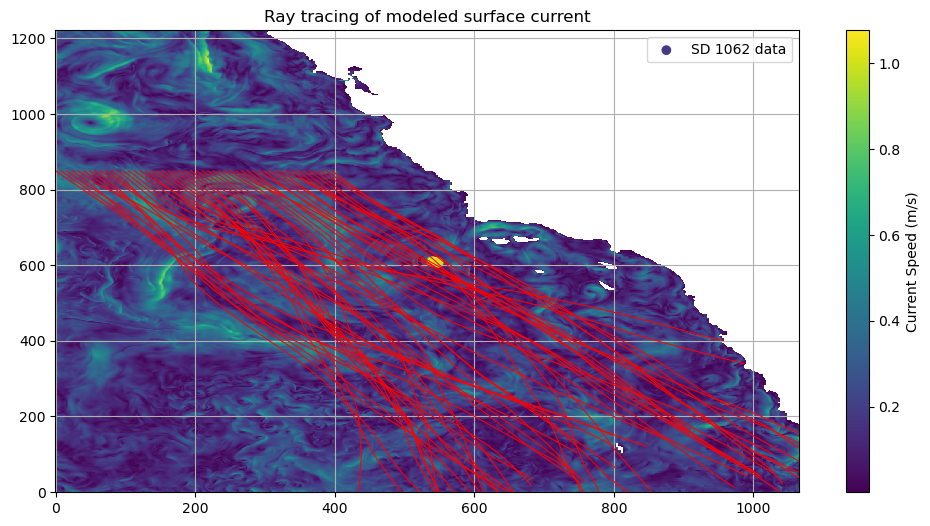

In [14]:
X = ds.x
Y = ds.y
U = (ds.u**2 + ds.v**2)**.5
plt.figure(figsize=(12, 6))
cs = plt.pcolormesh(X, Y, U)
for i in range(bundle.ray.size)[::2]:
    ray = bundle.isel(ray=i)
    plt.plot(ray.x, ray.y, 'red', lw=.75)
plt.scatter(sd_x_meters, sd_y_meters, c=non_masked, marker='o', label='SD 1062 data')
plt.legend(loc='upper right')
plt.title('Ray tracing of modeled surface current')
plt.colorbar(cs, label='Current Speed (m/s)')
plt.grid(axis='both')
#plt.savefig('large_scale_refraction_ray_tracing.png', dpi=300, bbox_inches='tight')